In [1]:
from fastai.text.all import *
import os
import pandas as pd
import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)
%config Completer.use_jedi = False

In [2]:
# Example of a validation dataset. In this case it is a list of python dictionaries.
# You should be able to adapt this to your usecase if you can read in a file using Pandas.
valid_jsons = [
    {"from_txt":"Hello how are you?","to_txt":"I am doing fine."},
    {"from_txt":"Is it going to rain today?","to_txt":"Let me pull up the weather."},
    {"from_txt":"How do fastai DataBlocks work?","to_txt":"Not sure, I'm still learning."}
]

# Read the list of dicts into a Data Frame
df_valid = pd.DataFrame(valid_jsons)

# Add a is_valid colum. The ColSplitter() function below expects this column.
df_valid['is_valid'] = True

# View our work
df_valid.head()

,from_txt,to_txt,is_valid
0,Hello how are you?,I am doing fine.,True
1,Is it going to rain today?,Let me pull up the weather.,True
2,How do fastai DataBlocks work?,"Not sure, I'm still learning.",True


In [3]:
# Example of a test dataset. In this case it is a list of python dictionaries.
# You should be able to adapt this to your usecase if you can read in a file using Pandas.
test_jsons = [
    {"from_txt":"Hello, where is the closest McDonald's?","to_txt":"Let me find you that on Google Maps."},
    {"from_txt":"Is it going to snow today?","to_txt":"Let me pull up the weather."},
    {"from_txt":"How much coffee is safe to drink?","to_txt":"As much as you need to learn the Fastai Library."}
]

# Read the list of dicts into a Data Frame
df_train = pd.DataFrame(test_jsons)


# Add a is_valid colum
df_train['is_valid'] = False

# View our work
df_train.head()

,from_txt,to_txt,is_valid
0,"Hello, where is the closest McDonald's?",Let me find you that on Google Maps.,False
1,Is it going to snow today?,Let me pull up the weather.,False
2,How much coffee is safe to drink?,As much as you need to learn the Fastai Library.,False


In [4]:
# Stack the two dataframes into one.
df = pd.concat([df_train,df_valid], ignore_index=True)
df.head()

,from_txt,to_txt,is_valid
0,"Hello, where is the closest McDonald's?",Let me find you that on Google Maps.,False
1,Is it going to snow today?,Let me pull up the weather.,False
2,How much coffee is safe to drink?,As much as you need to learn the Fastai Library.,False
3,Hello how are you?,I am doing fine.,True
4,Is it going to rain today?,Let me pull up the weather.,True


In [5]:
logs = DataBlock(
    
    # blocks specify what type of data we are going to be loading.
    # In this case both are text files contained in the same df   
    # You can specify a tokenizer by passing in a tok variable. Comment the line above and ucomment the onces below.
    blocks=(
        TextBlock.from_df('from_txt', is_lm=False, tok=SubwordTokenizer(vocab_sz=200)),
        TextBlock.from_df('to_txt'  , is_lm=False, tok=SubwordTokenizer(vocab_sz=200))),

    # The TestBlock tokenization process puts tokenized inputs into a column called text. 
    # The ColReader for get_x will always reference text, even if the original text inputs 
    # were in a column with another name in the dataframe.
    get_x=ColReader('text'),
    get_y=ColReader('text'),
    
    # The dataframe needs to have a is_valid column for this to work.
    splitter=ColSplitter()

)

In [6]:
dls = logs.dataloaders(df,bs=2,)

dls.show_batch(max_n=2)

,text,text_
0,▁xxbos ▁xxmaj xxunk xxunk xxunk xxunk r e ▁i s xxunk xxunk xxunk xxunk s e xxunk xxunk c xxunk xxunk a xxunk xxunk xxunk s ?,▁xxbos ▁xxmaj ▁le t ▁m e xxunk d ▁ y o u xxunk xxunk ▁ o xxunk ▁xxmaj ▁ xxunk o o xxunk xxunk ▁xxmaj ▁m a p xxunk .
1,▁xxbos ▁xxmaj ▁h o w xxunk xxunk c xxunk xxunk o xxunk xxunk e ▁i s ▁ s a xxunk ▁to xxunk r in k ?,▁xxbos ▁xxmaj ▁ as ▁m u xxunk xxunk ▁ as ▁ y o u ▁ xxunk e d ▁ t o xxunk ▁the ▁xxmaj xxunk as t a i ▁xxmaj ▁ l i xxunk r xxunk y .


In [7]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()
        
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        
        self.embedding = nn.Embedding(input_dim, emb_dim)
        
        self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, dropout = dropout)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src):
        
        #src = [src len, batch size]
        
        embedded = self.dropout(self.embedding(src))
        
        #embedded = [src len, batch size, emb dim]
        
        outputs, (hidden, cell) = self.rnn(embedded)
        
        #outputs = [src len, batch size, hid dim * n directions]
        #hidden = [n layers * n directions, batch size, hid dim]
        #cell = [n layers * n directions, batch size, hid dim]
        
        #outputs are always from the top hidden layer
        
        return hidden, cell

In [8]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()
        
        self.output_dim = output_dim
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        
        self.embedding = nn.Embedding(output_dim, emb_dim)
        
        self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, dropout = dropout)
        
        self.fc_out = nn.Linear(hid_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, hidden, cell):
        
        #input = [batch size]
        #hidden = [n layers * n directions, batch size, hid dim]
        #cell = [n layers * n directions, batch size, hid dim]
        
        #n directions in the decoder will both always be 1, therefore:
        #hidden = [n layers, batch size, hid dim]
        #context = [n layers, batch size, hid dim]
        
        input = input.unsqueeze(0)
        
        #input = [1, batch size]
        
        embedded = self.dropout(self.embedding(input))
        
        #embedded = [1, batch size, emb dim]
                
        output, (hidden, cell) = self.rnn(embedded, (hidden, cell))
        
        #output = [seq len, batch size, hid dim * n directions]
        #hidden = [n layers * n directions, batch size, hid dim]
        #cell = [n layers * n directions, batch size, hid dim]
        
        #seq len and n directions will always be 1 in the decoder, therefore:
        #output = [1, batch size, hid dim]
        #hidden = [n layers, batch size, hid dim]
        #cell = [n layers, batch size, hid dim]
        
        prediction = self.fc_out(output.squeeze(0))
        
        #prediction = [batch size, output dim]
        
        return prediction, hidden, cell
        

In [9]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
        assert encoder.hid_dim == decoder.hid_dim, \
            "Hidden dimensions of encoder and decoder must be equal!"
        assert encoder.n_layers == decoder.n_layers, \
            "Encoder and decoder must have equal number of layers!"
        
    def forward(self, src, trg, teacher_forcing_ratio = 0.5):
        
        #src = [src len, batch size]
        #trg = [trg len, batch size]
        #teacher_forcing_ratio is probability to use teacher forcing
        #e.g. if teacher_forcing_ratio is 0.75 we use ground-truth inputs 75% of the time
        
        batch_size = trg.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        
        #tensor to store decoder outputs
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        
        #last hidden state of the encoder is used as the initial hidden state of the decoder
        hidden, cell = self.encoder(src)
        
        #first input to the decoder is the <sos> tokens
        input = trg[0,:]
        
        for t in range(1, trg_len):
            
            #insert input token embedding, previous hidden and previous cell states
            #receive output tensor (predictions) and new hidden and cell states
            output, hidden, cell = self.decoder(input, hidden, cell)
            
            #place predictions in a tensor holding predictions for each token
            outputs[t] = output
            
            #decide if we are going to use teacher forcing or not
            teacher_force = random.random() < teacher_forcing_ratio
            
            #get the highest predicted token from our predictions
            top1 = output.argmax(1) 
            
            #if teacher forcing, use actual next token as next input
            #if not, use predicted token
            input = trg[t] if teacher_force else top1
        
        return outputs
        

In [10]:
INPUT_DIM = len(dls.train.vocab[0])
OUTPUT_DIM = len(dls.train.vocab[0])
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
N_LAYERS = 2
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)



device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Seq2Seq(enc, dec, device)

In [11]:
class TeacherForcingCallback(Callback):
    """
    Callback that sends the y's to the model too
    """
    def before_batch(self):
        x,y = self.x, self.y
        self.learn.xb = (x,y)



In [12]:
criterion = CrossEntropyLossFlat()

In [13]:
learn = Learner(dls, model, loss_func=criterion, cbs=[TeacherForcingCallback()])

SuggestedLRs(lr_min=0.03019951581954956, lr_steep=0.007585775572806597)

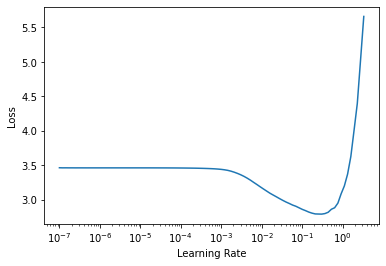

In [14]:
learn.lr_find()

In [15]:
learn.fit(lr=0.00758,n_epoch=5)

epoch,train_loss,valid_loss,time
0,3.461550,3.440783,00:00
1,3.385622,3.416905,00:00
2,3.210700,3.603085,00:00
3,3.052687,3.915920,00:00
4,2.909844,4.111388,00:00
